In [1]:
from IPython.display import Image
from os import chdir
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# read the file
file_name = "function_rips_with_threshold_100_1"
#file_name="fig3-2"

rank_dim = 0

simplices = []
vertice_id = 0
i = 0

x_values = []
y_values = []

for line in open("../cgta_paper_2021/function_rips/"+file_name+".scc"):
#for line in open("./data/"+file_name+".txt"):
    if(line[0]!='#'):
        
        if(i<=1):
            i=i+1
            continue
            
        elif(i==2):
            rank_num=[] # sizes of generating sets
            for j in line.split():
                rank_num.append(int(j))
            i=i+1
            rank_num=rank_num[:-1]
            print("rank_num=",rank_num)
        else:
            block = line.split(';')
            grid = block[0].split()
            grid_x = float(grid[0])
            grid_y = float(grid[1])
            #grid_x = int(float(grid[0])*20)
            #grid_y = int(float(grid[1])*20)
            x_values.append(grid_x)
            y_values.append(grid_y)
            
            
            if len(block)>1:
                face = block[1].split()
                for j in range(len(face)):
                    face[j] = int(face[j])
                simplices.append([grid_x,grid_y,face])
                
            else:
                simplices.append([grid_x,grid_y,[vertice_id]])
                vertice_id += 1
            i=i+1   




simplex_tree = []
start_id=0
for i in range(len(rank_num)-1,-1,-1):
    simplices_i=[]
    for j in range(len(simplices)-start_id-rank_num[i],len(simplices)-start_id):
        simplices_i.append(simplices[j])
    start_id += rank_num[i]
    simplex_tree.append(simplices_i)
    


#transform face number to vertex number
for i in range(1,len(simplex_tree)):
    for j in range(len(simplex_tree[i])):
        simplex = simplex_tree[i][j]
        face = simplex[2]
        vertices=[]
        for face_id in face:
            vert = simplex_tree[i-1][face_id][2]
            for vert_id in vert:
                if vert_id not in vertices:
                    vertices.append(vert_id)
        simplex_tree[i][j][2]=vertices



## To verify the data structur
## simplices contain all the information we need
#print("the simplex tree:")
#for i in range(len(simplex_tree)):
#    for simplex in simplex_tree[i]:
#        print(simplex)   

       


rank_num= [5, 10, 10, 5]


In [3]:

x_values_ordered = sorted(list({}.fromkeys(x_values).keys()))
y_values_ordered = sorted(list({}.fromkeys(y_values).keys()))


simplex_tree_integer=simplex_tree

for i in range(len(simplex_tree_integer)):
    for j in range(len(simplex_tree_integer[i])):
        simplex_tree_integer[i][j][0]=x_values_ordered.index(simplex_tree_integer[i][j][0])
        simplex_tree_integer[i][j][1]=y_values_ordered.index(simplex_tree_integer[i][j][1])




In [4]:
x_range=len(x_values_ordered)-1
y_range=len(y_values_ordered)-1

end_point = [x_range,y_range]
print("end_point ",end_point)

end_point  [10, 0]


## Compute rank invariant

In [5]:
def create_stair(elbow, end_point):
    # stair a path passing through the elbow.
    stair = []
    
    if(elbow[0]==0 or elbow[1]==end_point[1]):
        for i in range(end_point[1]+1):
            stair.append([0,i])
        for j in range(1,end_point[0]+1):
            stair.append([j,i])
    else:
        for i in range(elbow[1]+1):
            stair.append([0,i])   # i=0
        for j in range(elbow[0]):
            stair.append([j+1,i]) # j=0
        for k in range(i+1, end_point[1]+1):
            stair.append([j+1,k]) # k=2,3
        for l in range(j+2, end_point[0]+1):
            stair.append([l,k])
    return stair

def compute_rk(i,j,k,l,barcodes,rank_dim):
# This function computes the value rank(s,t) where s=(i,j) and t = (k,l)
    if(i>k or j>l):
        return 0
    
    s_1 = i + j
    t_1 = k + l
    rank0_inv = 0
    rank1_inv = 0

    for barcode in barcodes:
        if(barcode[0]==0):
            if(barcode[1][0]<=s_1 and barcode[1][1]>t_1):
                rank0_inv = rank0_inv + 1
        elif(barcode[0]==1):
            if(barcode[1][0]<=s_1 and barcode[1][1]>t_1):
                rank1_inv = rank1_inv + 1
    if(rank_dim==0):
        return rank0_inv
    elif(rank_dim==1):
        return rank1_inv
    

In [6]:
import time
#grid is from (0,0)
#vertex index is from 1
rank_inv = np.array(np.zeros((x_range+1,y_range+1,x_range+1,y_range+1)))

st = gd.SimplexTree()
#result_rank_fn="./result/rank1_invariance_for_"+file_name+".txt"
#f_rank = f.open(result_rank_fn,"w")



#Scan all the elbows
for i in range(x_range+1):
    for j in range(y_range+1):
        elbow = [i,j]
        print("elbow",elbow)
        start_time=time.time()
        #print("time: start building a simplex tree",time.time())
        stair = create_stair(elbow, end_point)
        #print("stair",stair)

        # Build the simplex tree
        
        for ii in range(len(simplex_tree_integer)):
            for jj in range(len(simplex_tree_integer[ii])):
                simplex = simplex_tree_integer[ii][jj]
                for grid_id in stair:
                    if simplex[0]<=grid_id[0] and simplex[1]<=grid_id[1]:
                        filtration_value = grid_id[0]+grid_id[1] #TODO
                        #print("time enter insert/assign ", time.asctime( time.localtime(time.time())))
                        if((st.insert(simplex[2], filtration = filtration_value))==False): #TODO:optimize with C++, we don't have the funciton for Python
                            #print("time finish insert",time.asctime( time.localtime(time.time())))
                            st.assign_filtration(simplex[2], filtration = filtration_value)
                        break
                        
        st_time=time.time()                
        print("time of building a simplex tree",st_time-start_time,"s")
        print("simplices ",st.num_simplices())
        print("vertices ", st.num_vertices())
        #st_gen = st.get_filtration() 
        #for splx in st_gen :
        #    print(splx)
        
        barcodes = st.persistence()
        #print("barcodes,",barcodes)
        bc_time =time.time()
        print("time of calculating barcodes ",bc_time-st_time,"s")
        
        for start_id in range(len(stair)):
            for end_id in range(start_id,len(stair)):
                grid_start = stair[start_id]
                grid_end = stair[end_id]
                [ri,rj,rk,rl]=[grid_start[0],grid_start[1],grid_end[0],grid_end[1]]
                #print("[ri,rj,rk,rl]=",[ri,rj,rk,rl])
                rank_inv[ri,rj,rk,rl]=compute_rk(ri,rj,rk,rl,barcodes,rank_dim)
        ri_time = time.time()
        print("time of finishing calculating rank invariance",ri_time-bc_time,"s")
        print("total time for one elbow ",ri_time-start_time,"s")

        
                

elbow [0, 0]
time of building a simplex tree 0.0001499652862548828 s
simplices  30
vertices  5
time of calculating barcodes  0.0002639293670654297 s
time of finishing calculating rank invariance 0.0009031295776367188 s
total time for one elbow  0.0013170242309570312 s
elbow [1, 0]
time of building a simplex tree 0.00012803077697753906 s
simplices  30
vertices  5
time of calculating barcodes  0.0008842945098876953 s
time of finishing calculating rank invariance 0.0008137226104736328 s
total time for one elbow  0.0018260478973388672 s
elbow [2, 0]
time of building a simplex tree 0.0001919269561767578 s
simplices  30
vertices  5
time of calculating barcodes  0.0006659030914306641 s
time of finishing calculating rank invariance 0.0002970695495605469 s
total time for one elbow  0.0011548995971679688 s
elbow [3, 0]
time of building a simplex tree 0.00019097328186035156 s
simplices  30
vertices  5
time of calculating barcodes  0.0006878376007080078 s
time of finishing calculating rank invaria

In [7]:
#Now it's rank0_invariance
np.save("./result/rank"+str(rank_dim)+"_invariance_for_"+file_name,rank_inv)

#for i in range(x_range+1):
#    for j in range(y_range+1):
#        for k in range(i,x_range+1):
#            for l in range(j,y_range+1):
#                print("rank(({0},{1}),({2},{3}))={4}".format(i,j,k,l,int(rank_inv[i,j,k,l])))


## compute multiplicity

In [8]:
#
#m((i,j),(k,l))
def multp(rank, i,j,k,l):
    if(i<0 or j<0 or k>rank.shape[1] or l>rank.shape[0]):   
        return 0
    
    res = rank[i,j,k,l]
    #print("res=",res)
    if(k+1<rank.shape[0]):
        #print("rank[i,j,k+1,l]=",rank[i,j,k+1,l])
        res -= rank[i,j,k+1,l]
        #print("res=",res)
    if(l+1<rank.shape[1]):
        #print("rank[i,j,k,l+1]=",rank[i,j,k,l+1])
        res -= rank[i,j,k,l+1]
        #print("res=",res)
    if(k+1<rank.shape[0] and l+1<rank.shape[1]):
        #print("rank[i,j,k+1,l+1]=",rank[i,j,k+1,l+1])
        res += rank[i,j,k+1,l+1]
        #print("res=",res)
    #print("=================multp(({0},{1}),({2},{3}))={4}===================".format(i,j,k,l,res))
    return res
    

def compute_R_S_incl_excl(rank):
    multiplicity = np.zeros_like(rank)
    for i in range(rank.shape[0]):
        for j in range(rank.shape[1]):
            for k in range(i,rank.shape[0]):
                for l in range(j,rank.shape[1]):
                    m = multp(rank,i,j,k,l)-multp(rank,i-1,j,k,l)-multp(rank,i,j-1,k,l)+multp(rank,i-1,j-1,k,l)
                    if(m!=0):
                        multiplicity[i,j,k,l] = m
    return multiplicity
    

In [9]:
rank_inv.shape

(11, 1, 11, 1)

In [10]:
m_start_time = time.time()
m = compute_R_S_incl_excl(rank_inv)

m_end_time = time.time()
print("time of calculating multiplicity:",m_end_time-m_start_time,"s")

np.save("./result/rank"+str(rank_dim)+"_multiplicity_for_"+file_name,m)

time of calculating multiplicity: 0.0001773834228515625 s


### Draw grid for multiplicity

(11, 1, 11, 1)
m((0,0),(0,0))=1
m((0,0),(1,0))=1


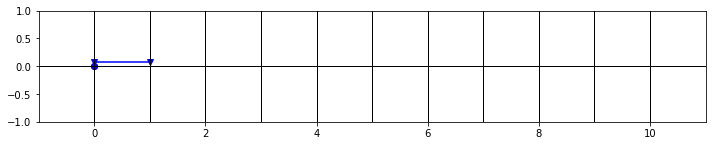

In [11]:
data = np.ones((x_range,y_range)) * np.nan

fig, ax = plt.subplots(1, 1, figsize=(10,10),tight_layout=True)
for x in range(x_range+1):
    ax.axvline(x, lw=1, color='k', zorder=5) # Horizontal 
for y in range(y_range+1):
    ax.axhline(y, lw=1, color='k', zorder=5) # Ordinate
print(m.shape)

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        for k in range(i,m.shape[0]):
            for l in range(j,m.shape[1]):
                if(m[i,j,k,l]):
                    print("m(({0},{1}),({2},{3}))={4}".format(i,j,k,l,int(m[i,j,k,l])))
                if(m[i,j,k,l]>0):
                    if(i==k and j==l):
                        ax.plot([i, k], [j, l],'bo', linestyle="-")
                    elif(i==k):
                        ax.plot([i+0.08, k+0.08], [j, l],'bv', linestyle="-")
                    elif(j==l):
                        ax.plot([i, k], [j+0.08, l+0.08],'bv',linestyle="-")
                    else:  
                        ax.plot([i, k], [j, l],'bv', linestyle="-")
                if(m[i,j,k,l]<0):
                    if(i==k and j==l):
                        ax.plot([i, k], [j, l],'ro', linestyle="-")
                    elif(i==k):
                        ax.plot([i-0.08, k-0.08], [j, l],'rv', linestyle="-")
                    elif(j==l):
                        ax.plot([i, k], [j-0.08, l-0.08],'rv', linestyle="-")
                    else:  
                        ax.plot([i, k], [j, l], 'rv', linestyle="-")

ax.imshow(data, interpolation='none', extent=[-1,x_range+1, -1, y_range+1], zorder=0)

#ax.axis('off')